# Promoter region methylation-RNAseq correlation

### Mamie Wang (szmamie@stanford.edu)
### 2018/02/27

## This note aims to explore the correlation between methylation M value and RNA-seq RSEM level for HM 450K 

## objective
- subset probes with `UCSC_RefGene_Group` as `TSS1500` (within 200 bp - 1500 bp upstream of the transcription start site)
- subset probes at CpG island and shore
- compute the correlation between methylation and corresponding gene expression level

In [1]:
library(dplyr)
library(ggplot2)


Attaching package: ‘dplyr’

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union



## Illumina HumanMethylation 450 manifest file
- UCSC_RefGene_Group: functional regions with genes that a probe is associated to
- Relation_to_UCSC_CpG_Island: relation of the probe to one or more CpG islands

In [3]:
annotations = read.csv('../data/HumanMethylation450_15017482_v1-2.csv',
                        sep=',', stringsAsFactors=F, skip=7, header=T)
row.names(annotations) = annotations$IlmnID

In [4]:
head(annotations)

,IlmnID,Name,AddressA_ID,AlleleA_ProbeSeq,AddressB_ID,AlleleB_ProbeSeq,Infinium_Design_Type,Next_Base,Color_Channel,Forward_Sequence,⋯,UCSC_RefGene_Group,UCSC_CpG_Islands_Name,Relation_to_UCSC_CpG_Island,Phantom,DMR,Enhancer,HMM_Island,Regulatory_Feature_Name,Regulatory_Feature_Group,DHS
cg00035864,cg00035864,cg00035864,31729416,AAAACACTAACAATCTTATCCACATAAACCCTTAAATTTATCTCAAATTC,,,II,,,AATCCAAAGATGATGGAGGAGTGCCCGCTCATGATGTGAAGTACCTGCTCAGCTGGAAAC[CG]AATTTGAGATAAATTCAAGGGTCTATGTGGACAAGACTGCTAGTGTCTCTCTCTGGATTG,⋯,TSS1500,,,,,NA,,,,NA
cg00050873,cg00050873,cg00050873,32735311,ACAAAAAAACAACACACAACTATAATAATTTTTAAAATAAATAAACCCCA,31717405,ACGAAAAAACAACGCACAACTATAATAATTTTTAAAATAAATAAACCCCG,I,A,Red,TATCTCTGTCTGGCGAGGAGGCAACGCACAACTGTGGTGGTTTTTGGAGTGGGTGGACCC[CG]GCCAAGACGGCCTGGGCTGACCAGAGACGGGAGGCAGAAAAAGTGGGCAGGTGGTTGCAG,⋯,Body;TSS1500,chrY:9363680-9363943,N_Shore,,,NA,Y:9973136-9976273,,,NA
cg00061679,cg00061679,cg00061679,28780415,AAAACATTAAAAAACTAATTCACTACTATTTAATTACTTTATTTTCCATC,,,II,,,TCAACAAATGAGAGACATTGAAGAACTAATTCACTACTATTTGGTTACTTTATTTTCCAT[CG]AAGAAAACCTCTTTTTAAAAACTAACACATAAATAAAATGAACGAAGAACAAACTAAACG,⋯,Body;Body;Body,,,,,NA,,,,NA
cg00063477,cg00063477,cg00063477,16712347,TATTCTTCCACACAAAATACTAAACRTATATTTACAAAAATACTTCCATC,,,II,,,CTCCTGTACTTGTTCATTAAATAATGATTCCTTGGATATACCAAGTCTGGATAGCGGATT[CG]ATGGAAGCATTTTTGTAAATATACGTTCAGTATTTTGTGTGGAAGAACACAATCTAGCTG,⋯,Body,chrY:22737825-22738052,S_Shelf,,,NA,,,,NA
cg00121626,cg00121626,cg00121626,19779393,AAAACTAATAAAAATAACTTACAAACCAAATACTATACCCTACAACTCTC,,,II,,,AGGTGAATGAAGAGACTAATGGGAGTGGCTTGCAAGCCAGGTACTGTGCCCTACAACTCT[CG]CGCTGCCACAAAAAGCCAATTAACGAAGCAAACTGTTTTATCTTTTCCTCTCCCCAGAAG,⋯,Body,chrY:21664481-21665063,N_Shore,,,NA,,,,NA
cg00212031,cg00212031,cg00212031,29674443,CCCAATTAACCACAAAAACTAAACAAATTATACAATCAAAAAAACATACA,38703326,CCCAATTAACCGCAAAAACTAAACAAATTATACGATCGAAAAAACGTACG,I,T,Red,CCATTGGCCCGCCCCAGTTGGCCGCAGGGACTGAGCAAGTTATGCGGTCGGGAAGACGTG[CG]TTAAAGGGCTGAAGGGGAGGGACGGAACTGACAGTCTCTGTGACAGCTCTGAGGTGGGAG,⋯,TSS200,chrY:21238448-21240005,Island,,,NA,Y:19697854-19699393,,,NA


## Subset promoter region probes
- `UCSC_RefGene_Group` contains `TSS1500`

In [5]:
probes.TSS1500 = annotations %>%
  filter(grepl('TSS1500', UCSC_RefGene_Group, fixed=T))

In [6]:
head(probes.TSS1500)

IlmnID,Name,AddressA_ID,AlleleA_ProbeSeq,AddressB_ID,AlleleB_ProbeSeq,Infinium_Design_Type,Next_Base,Color_Channel,Forward_Sequence,⋯,UCSC_RefGene_Group,UCSC_CpG_Islands_Name,Relation_to_UCSC_CpG_Island,Phantom,DMR,Enhancer,HMM_Island,Regulatory_Feature_Name,Regulatory_Feature_Group,DHS
cg00035864,cg00035864,31729416,AAAACACTAACAATCTTATCCACATAAACCCTTAAATTTATCTCAAATTC,,,II,,,AATCCAAAGATGATGGAGGAGTGCCCGCTCATGATGTGAAGTACCTGCTCAGCTGGAAAC[CG]AATTTGAGATAAATTCAAGGGTCTATGTGGACAAGACTGCTAGTGTCTCTCTCTGGATTG,⋯,TSS1500,,,,,NA,,,,NA
cg00050873,cg00050873,32735311,ACAAAAAAACAACACACAACTATAATAATTTTTAAAATAAATAAACCCCA,31717405,ACGAAAAAACAACGCACAACTATAATAATTTTTAAAATAAATAAACCCCG,I,A,Red,TATCTCTGTCTGGCGAGGAGGCAACGCACAACTGTGGTGGTTTTTGGAGTGGGTGGACCC[CG]GCCAAGACGGCCTGGGCTGACCAGAGACGGGAGGCAGAAAAAGTGGGCAGGTGGTTGCAG,⋯,Body;TSS1500,chrY:9363680-9363943,N_Shore,,,NA,Y:9973136-9976273,,,NA
cg00272582,cg00272582,73678371,AAATCTAAAAACCTACAACAATAAAATCTATCRCCTTAACTAAAACTAAC,,,II,,,ACTGAGGGCGGGGGTCTAAGGGCCTGCAACAATGAGATCTGTCGCCTTGGCTAGGACTGG[CG]CCGAGAGGCGATAGGTCTCGGGAGAGCCTGGCGCAGGGTGTGGGAGATTAGGAATCCCAG,⋯,TSS1500;TSS200;TSS1500,chrY:2802964-2804283,Island,,,NA,Y:2862947-2864321,,,NA
cg00311963,cg00311963,21726474,AATATAAAACRACTACTTCTCTAAATTCATAAACTACAAAAAACCTTTAC,,,II,,,GACTAGGATAAGAAGACACCACACACCCGGACATCAGCAGAGCATGTCCAGCACCCAGCA[CG]CAAAGGCCTCCTGCAGCTCATGAACCCAGAGAAGCAGCCGCCTCACACCACCCTGCCCCC,⋯,TSS1500;TSS1500,chrY:9745559-9745993,S_Shore,,,NA,,,,NA
cg00335297,cg00335297,53713392,ATCCTTATAAAATTTCAACTTCTATTACAAACAAATTCCACCCCAACAAC,,,II,,,GACCTTAGAGAGTCCTTGTGGGGTTTCAGCTTCTATTGCAGACAAATTCCACCCCAGCAA[CG]TACCAGTCGACTTTCCTCACAGGCAACCGCCCTGCCCCACTCCCCTCAAACCACCGCCGC,⋯,TSS1500;TSS1500,chrY:24454804-24455083,N_Shore,,,NA,Y:22863915-22863999,,,NA
cg01053349,cg01053349,10737353,ACRCCTATCACTTTCTTCCTATTTAATTTTACTCTAATATTATTCTTCCC,,,II,,,TAATCAACAATTTGTTCCTGATATATCTAGATGAGCCAGTGAGACAATTATAAGTAATAA[CG]GGAAGAACAATACCAGAGTAAAATCAAATAGGAAGAAAGTGATAGGCGTATTTACACTAA,⋯,TSS1500,,,,,NA,,,,NA


In [7]:
dim(probes.TSS1500)

[1] 84342    33

# Further subset probes within CpG island or shore
- CGI shore definition: up to 2kbp away from the CGI
- `Relation_to_UCSC_CpG_Island` contains `Shore` or `Island`

In [8]:
probes.CGI = probes.TSS1500 %>%
  filter(grepl('Shore|Island', Relation_to_UCSC_CpG_Island))

In [9]:
head(probes.CGI)

IlmnID,Name,AddressA_ID,AlleleA_ProbeSeq,AddressB_ID,AlleleB_ProbeSeq,Infinium_Design_Type,Next_Base,Color_Channel,Forward_Sequence,⋯,UCSC_RefGene_Group,UCSC_CpG_Islands_Name,Relation_to_UCSC_CpG_Island,Phantom,DMR,Enhancer,HMM_Island,Regulatory_Feature_Name,Regulatory_Feature_Group,DHS
cg00050873,cg00050873,32735311,ACAAAAAAACAACACACAACTATAATAATTTTTAAAATAAATAAACCCCA,31717405,ACGAAAAAACAACGCACAACTATAATAATTTTTAAAATAAATAAACCCCG,I,A,Red,TATCTCTGTCTGGCGAGGAGGCAACGCACAACTGTGGTGGTTTTTGGAGTGGGTGGACCC[CG]GCCAAGACGGCCTGGGCTGACCAGAGACGGGAGGCAGAAAAAGTGGGCAGGTGGTTGCAG,⋯,Body;TSS1500,chrY:9363680-9363943,N_Shore,,,NA,Y:9973136-9976273,,,NA
cg00272582,cg00272582,73678371,AAATCTAAAAACCTACAACAATAAAATCTATCRCCTTAACTAAAACTAAC,,,II,,,ACTGAGGGCGGGGGTCTAAGGGCCTGCAACAATGAGATCTGTCGCCTTGGCTAGGACTGG[CG]CCGAGAGGCGATAGGTCTCGGGAGAGCCTGGCGCAGGGTGTGGGAGATTAGGAATCCCAG,⋯,TSS1500;TSS200;TSS1500,chrY:2802964-2804283,Island,,,NA,Y:2862947-2864321,,,NA
cg00311963,cg00311963,21726474,AATATAAAACRACTACTTCTCTAAATTCATAAACTACAAAAAACCTTTAC,,,II,,,GACTAGGATAAGAAGACACCACACACCCGGACATCAGCAGAGCATGTCCAGCACCCAGCA[CG]CAAAGGCCTCCTGCAGCTCATGAACCCAGAGAAGCAGCCGCCTCACACCACCCTGCCCCC,⋯,TSS1500;TSS1500,chrY:9745559-9745993,S_Shore,,,NA,,,,NA
cg00335297,cg00335297,53713392,ATCCTTATAAAATTTCAACTTCTATTACAAACAAATTCCACCCCAACAAC,,,II,,,GACCTTAGAGAGTCCTTGTGGGGTTTCAGCTTCTATTGCAGACAAATTCCACCCCAGCAA[CG]TACCAGTCGACTTTCCTCACAGGCAACCGCCCTGCCCCACTCCCCTCAAACCACCGCCGC,⋯,TSS1500;TSS1500,chrY:24454804-24455083,N_Shore,,,NA,Y:22863915-22863999,,,NA
cg01426558,cg01426558,29643447,AACRTTAATTATAACACACCTACAAAAAAACCTAAACCTAAACCCTTAAC,,,II,,,GGTCATTCAGTATATAATTGTTTCATTGTTTCGTGAAAACAAGGGACCTATGCCAGGGTG[CG]TTAAGGGCCTAGGCCTAGGTCCCCTTGTAGGTGTGTTATAATCAACGTCATTCAGTATGT,⋯,TSS1500;TSS1500,chrY:15016544-15017298,N_Shore,,,NA,,,,NA
cg01988452,cg01988452,17744441,TTTCTAATACATACAAACTACCAAAACTAACTTAAAAATAAATACAACAC,,,II,,,AAATGAACAAATTTCTGGTACATACAAACTACCAGAACTGACTTGGGAATAAATACAGCA[CG]AATTCATAATCCAAACTAAGGCCTAGGACCATTTAAAAAATTTACATCAATCCTCGAATG,⋯,TSS1500,chrY:22737825-22738052,N_Shore,,,NA,,,,NA


In [10]:
dim(probes.CGI)

[1] 64707    33

In [11]:
sort(table(probes.CGI$Relation_to_UCSC_CpG_Island))


S_Shore N_Shore  Island 
  16623   19508   28576 

In [13]:
write.table(probes.TSS1500, sep='\t', row.names=F, quote=F, file='../data/promoterRegionProbes/TSS1500.tsv')
write.table(probes.CGI, sep='\t', row.names=F, quote=F, file='../data/promoterRegionProbes/CGI.tsv')

## Correlation between methylation level and corresponding gene expression
- The correlation coefficient between methylation level and corresponding GEP for entire data and the two probe subsets were computed by `computeCorrelation.R` and `task.R`.

### Entire data set (Beta value)

In [1]:
load('../data/processed/Correlation.RData')
length(correlation)

[1] 171715

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


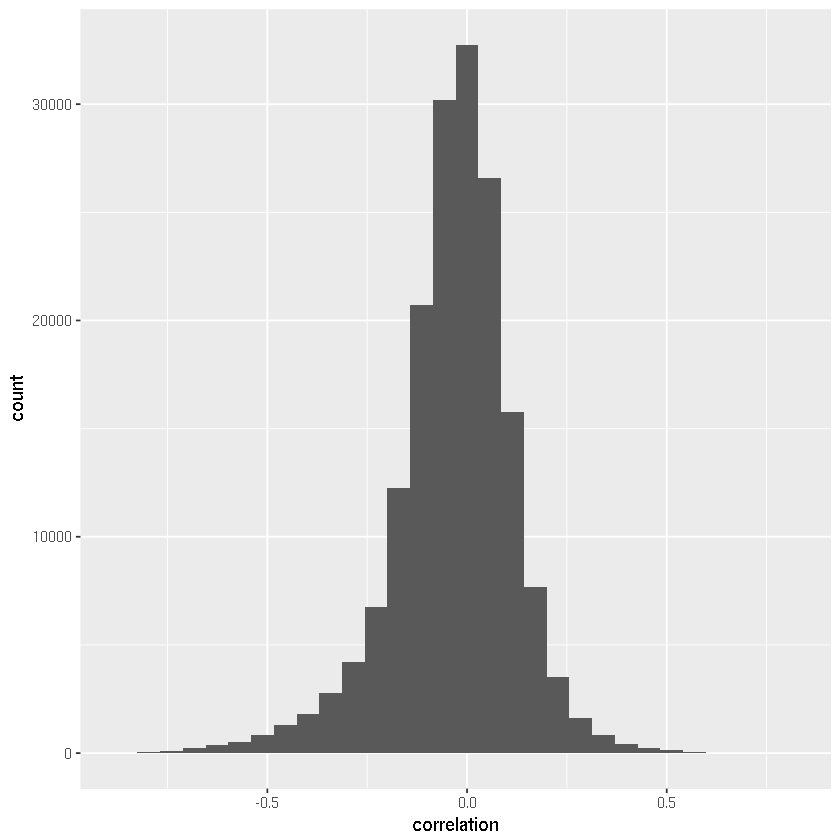

In [4]:
qplot(correlation, geom="histogram")

In [5]:
quantile(correlation)

0%         25%         50%         75%        100% 
-0.87778013 -0.10706584 -0.02188001  0.05552979  0.77326963

### Entire data set (M value)

In [1]:
load('../data/processed//CorrelationMvalue.RData')
length(correlation)

[1] 171715

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


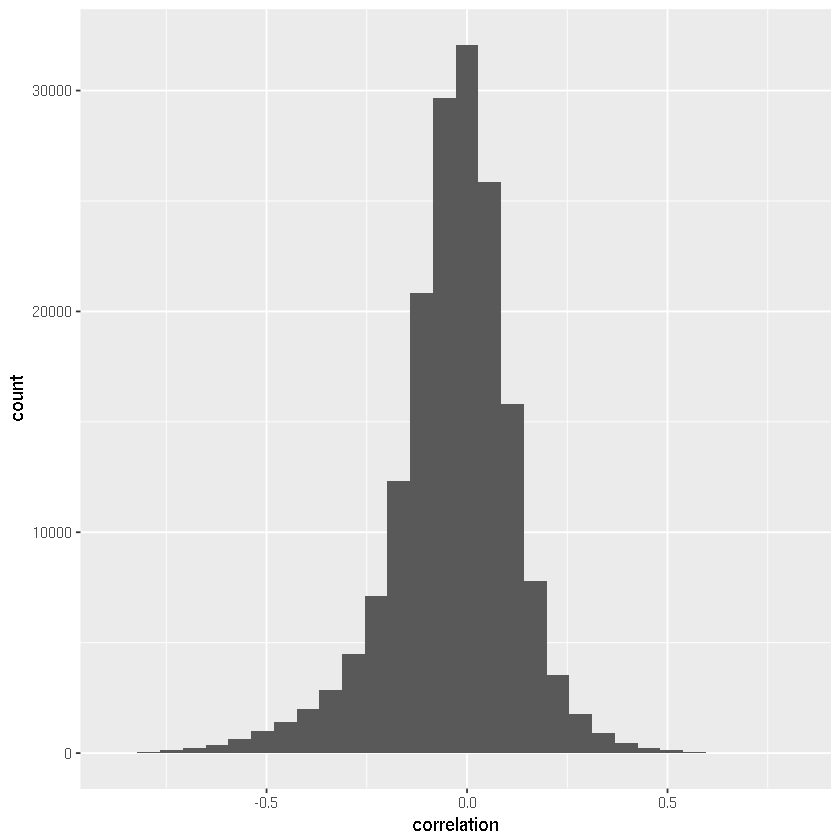

In [3]:
qplot(correlation, geom="histogram")

In [4]:
quantile(correlation)

0%         25%         50%         75%        100% 
-0.86615976 -0.11061239 -0.02342461  0.05547298  0.77844335

### Promoter region probes (Beta value)

In [2]:
load('../data/processed/CorrelationPromoterB.RData')
length(correlation)

[1] 29321

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


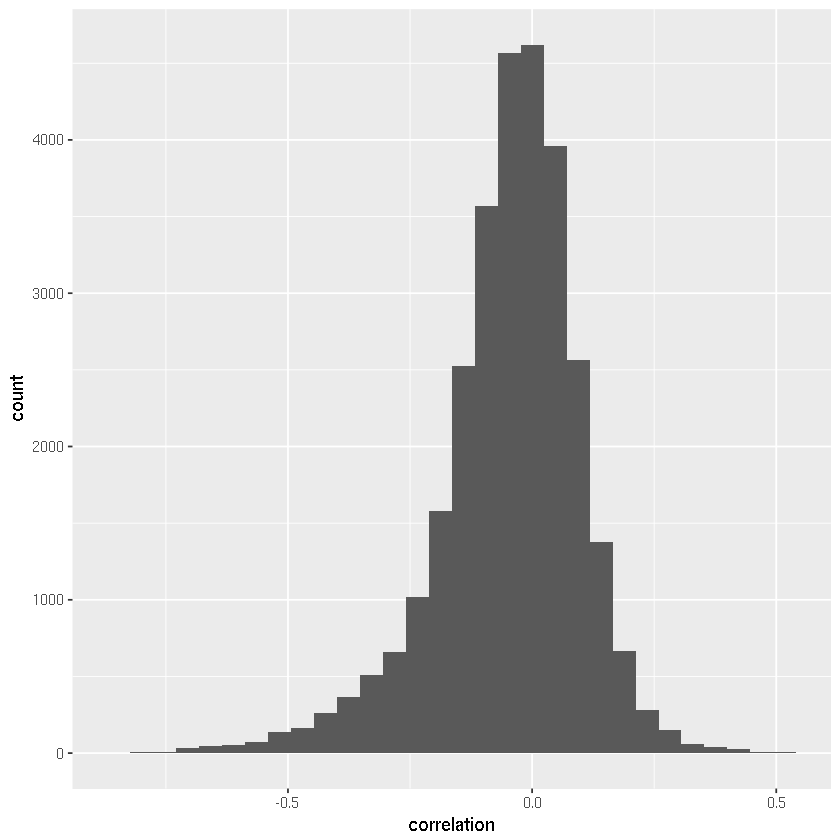

In [3]:
qplot(correlation, geom="histogram")

In [4]:
quantile(correlation)

0%         25%         50%         75%        100% 
-0.84402966 -0.11895568 -0.03274919  0.04362600  0.52087845

### Promoter region probes (M value)

In [5]:
load('../data/processed/CorrelationPromoterM.RData')
length(correlation)

[1] 29321

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


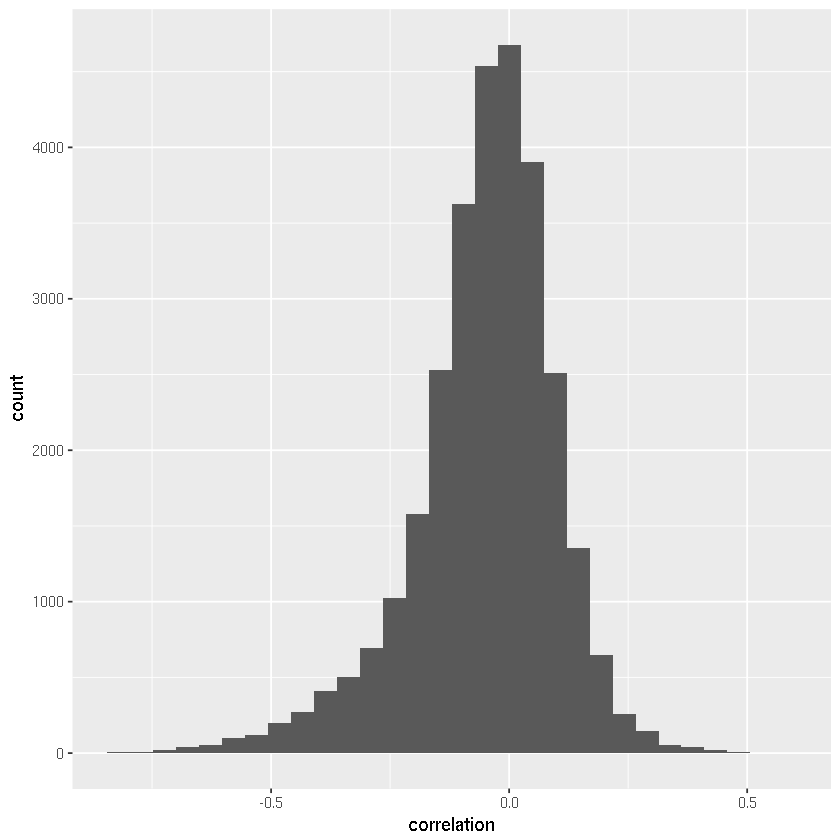

In [6]:
qplot(correlation, geom="histogram")

In [7]:
quantile(correlation)

0%         25%         50%         75%        100% 
-0.84298239 -0.12396484 -0.03496518  0.04241086  0.55691300

### Promoter + CGI/shore region (Beta value)

In [8]:
load('../data/processed/CorrelationCGIB.RData')
length(correlation)

[1] 25557

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


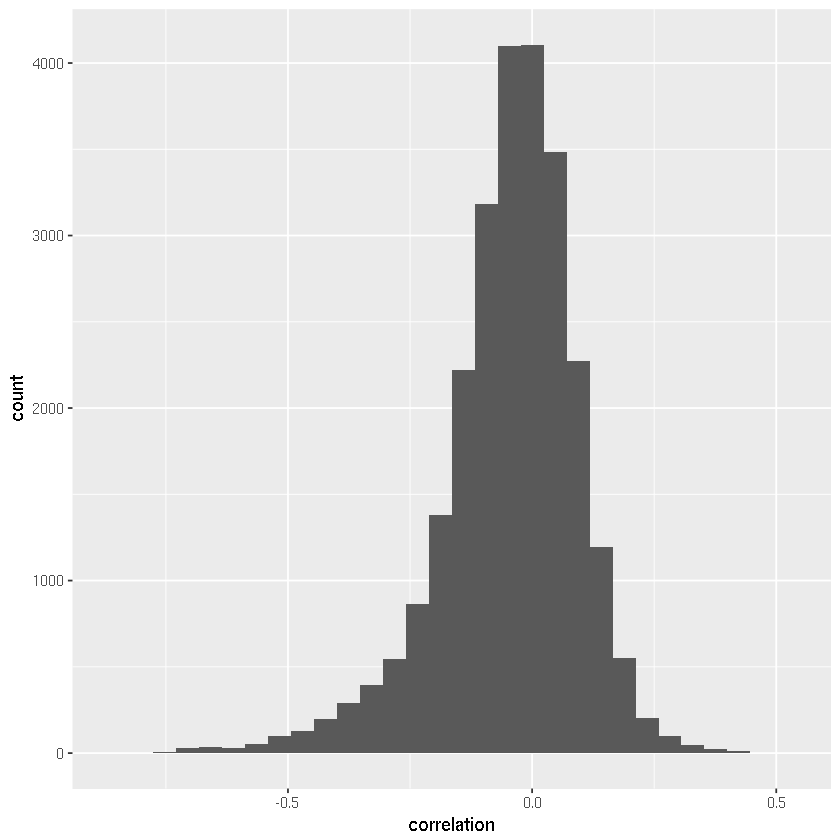

In [9]:
qplot(correlation, geom="histogram")

In [10]:
quantile(correlation)

0%         25%         50%         75%        100% 
-0.84402966 -0.11557512 -0.03212966  0.04240430  0.52087845

### Promoter + CGI/shore region (M value)

In [11]:
load('../data/processed/CorrelationCGIM.RData')
length(correlation)

[1] 25557

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


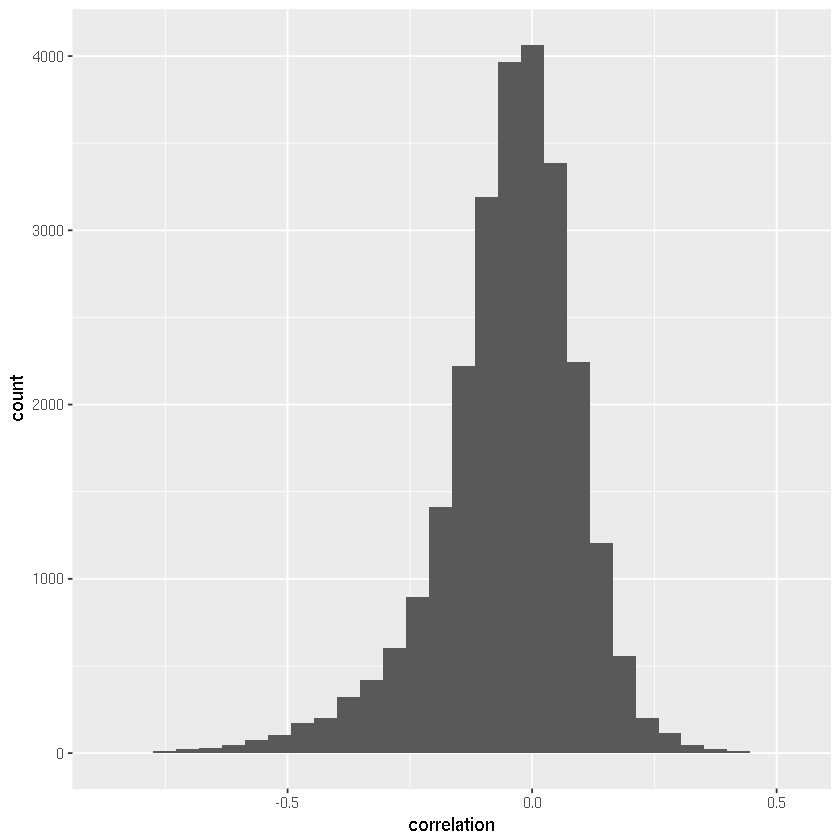

In [12]:
qplot(correlation, geom="histogram")

In [13]:
quantile(correlation)

0%         25%         50%         75%        100% 
-0.84298239 -0.12035593 -0.03415600  0.04152979  0.51981387

|  dataset name  |  0 %  |  25 % |  50 %  |  75 %  |  100 %  |  # samples  |
|----------------|-------|-------|--------|--------|---------|-------------|
|  all_beta      |-0.8778|-0.1071|-0.0219 |0.0555  |0.7733   | 171715      |
|  all_M         |-0.8662|-0.1106|-0.0234 |0.0555  |0.7784   | 171715      |
|  promoter_beta |-0.8440|-0.1190|-0.0327 |0.0436  |0.5209   | 29321       |
|  promoter_M    |-0.8429|-0.1240|-0.0350 |0.0424  |0.5569   | 29321       |
|  p+CGI_beta    |-0.8440|-0.1156|-0.0321 |0.0424  |0.5209   | 25557       |
|  p+CGI_M       |-0.8430|-0.1204|-0.0342 |0.0415  |0.5198   | 25557       |

## Update (03/08/2018)

- check the number of unique genes in three dataset (`all`, `promoter`, `promoter + CGI`) 
- obtain the top 100 most negative correlated gene probe

### All data

In [46]:
load('../data/processed/CorrelationM.RData')

In [47]:
head(correlation)

,gene,correlation
cg00000029,RBL2,-0.005897207
cg00000236,VDAC3,-0.402955754
cg00000289,ACTN1,0.003027153
cg00000292,ATP2A1,0.013048239
cg00000622,NIPA2,-0.058901265
cg00000658,MAN1B1,-0.197919831


In [48]:
dim(correlation)

[1] 171715      2

In [49]:
length(unique(correlation$gene))

[1] 10845

In [50]:
sort(table(correlation$gene), decreasing=T)[1:100]


  PTPRN2   MAD1L1     TNXB    DIP2C    RPTOR    HDAC4   INPP5A   ATP11A 
    1042      533      440      415      370      356      328      293 
   RASA3     TBCD    AGAP1  COL11A2   CAMTA1  RPS6KA2  ANKRD11  C7orf50 
     278      258      251      214      205      203      197      197 
    CUX1    KCNQ1    NCOR2  CBFA2T3 ARHGEF10  PRKAR1B     LMF1   TRIM26 
     197      190      189      181      179      174      170      169 
 TRAPPC9     BANP     BRD2   GABBR1   HRNBP3    CASZ1    FOXK1  SLC12A7 
     168      163      162      161      160      159      158      157 
  NFATC1    EHMT2      ABR     BAT2     LRP5    SEPT9  TSNARE1  CACNA1C 
     148      146      141      139      135      133      128      127 
     GAK      SKI   FBRSL1    OBSCN   TRIM27    IGF1R    RGS12   PRKAG2 
     127      126      123      122      121      119      119      118 
  KIF26B    PCGF3   NOTCH4  SYNGAP1     TRIO    FOXP1  B3GNTL1   RPH3AL 
     117      117      116      116      116      

#### correlation (all M)

In [51]:
topCorrelated <- correlation[order(correlation$correlation),][1:100,]
topCorrelated

,gene,correlation
cg11264499,MTX3,-0.8661598
cg03583857,CD34,-0.8429824
cg00129196,WDR35,-0.8372056
cg26266618,CD34,-0.8280892
cg08923054,ANK1,-0.8278396
cg26695784,FTO,-0.8277260
cg03276813,SSFA2,-0.8206695
cg20293352,CD34,-0.8135794
cg18294707,RNASE2,-0.8061969
cg06101274,ITPRIPL2,-0.8061266


In [52]:
write.table(topCorrelated, file='../data/processed/negCorProbes/topNegCorProbesAllM.tsv', quote=F, row.names=T, 
           col.names=T, sep='\t')

#### correlation (all B)

In [53]:
load('../data/processed/CorrelationB.RData')

In [54]:
topCorrelated <- correlation[order(correlation$correlation),][1:100,]
topCorrelated

,gene,correlation
cg03276813,SSFA2,-0.8777801
cg05210131,SSFA2,-0.8760448
cg09705174,SSFA2,-0.8538425
cg00129196,WDR35,-0.8525473
cg11264499,MTX3,-0.8483651
cg03583857,CD34,-0.8440297
cg26695784,FTO,-0.8389124
cg26266618,CD34,-0.8363744
cg19990182,WDR35,-0.8167212
cg02516189,CARD9,-0.8093841


In [55]:
write.table(topCorrelated, file='../data/processed/negCorProbes/topNegCorProbesAllB.tsv', quote=F, row.names=T, 
           col.names=T, sep='\t')

### Promoter

In [56]:
load('../data/processed/CorrelationPromoterM.RData')

In [57]:
dim(correlation)

[1] 29321     2

In [58]:
length(unique(correlation$gene))

[1] 8264

In [59]:
sort(table(correlation$gene), decreasing=T)[1:100]


     GNAS      HIC1      GFI1     BLCAP      BRD2     KCNQ1     RUNX3      BAT3 
       74        49        47        39        39        35        31        30 
    CCND2    OSBPL5    TRIM26     ASCL2     CCNA1    FGFRL1      TNXB     EHMT2 
       30        29        29        28        28        28        28        27 
     PAOX    BRP44L     PSMB8     GRB10    ATP10A     CCND1    HNRNPF      DAXX 
       27        26        26        25        24        24        24        23 
    TSSC4      BAT2    LY6G5C      UBTF    ZBTB12      CHFR      CTSZ     DUSP1 
       23        21        21        21        21        20        20        20 
    TGIF1      BCL2      CD81   COL11A2    DNMT3A      HLTF      LDB1    NAP1L4 
       20        19        19        19        19        19        19        19 
  C5orf13      CREM       GPT    HDAC11       MYC     RAB1B     SEPT9      SGK1 
       18        18        18        18        18        18        18        18 
    YWHAZ   ANKRD11       B

#### correlation (promoter M)

In [60]:
topCorrelated <- correlation[order(correlation$correlation),][1:100,]
topCorrelated

,gene,correlation
cg03583857,CD34,-0.8429824
cg26266618,CD34,-0.8280892
cg20293352,CD34,-0.8135794
cg18294707,RNASE2,-0.8061969
cg11197418,SUCLG2,-0.7913196
cg02852407,CD34,-0.7727605
cg00470794,CHFR,-0.7659533
cg27084026,CHFR,-0.7659373
cg14519294,CHFR,-0.7603678
cg00328227,C1orf59,-0.7554652


In [61]:
write.table(topCorrelated, file='../data/processed/negCorProbes/topNegCorProbesPromoterM.tsv', quote=F, row.names=T, 
           col.names=T, sep='\t')

#### correlation (promoter B)

In [62]:
load('../data/processed/CorrelationPromoterB.RData')
topCorrelated <- correlation[order(correlation$correlation),][1:100,]
topCorrelated

,gene,correlation
cg03583857,CD34,-0.8440297
cg26266618,CD34,-0.8363744
cg18294707,RNASE2,-0.8025127
cg11197418,SUCLG2,-0.7987677
cg02852407,CD34,-0.7895896
cg20293352,CD34,-0.7802990
cg14519294,CHFR,-0.7634431
cg27084026,CHFR,-0.7546301
cg26394825,CHFR,-0.7531514
cg00328227,C1orf59,-0.7460529


In [63]:
write.table(topCorrelated, file='../data/processed/negCorProbes/topNegCorProbesPromoterB.tsv', quote=F, row.names=T, 
           col.names=T, sep='\t')

### Promoter + CGI

In [64]:
load('../data/processed/CorrelationCGIM.RData')

In [65]:
dim(correlation)

[1] 25557     2

In [66]:
length(unique(correlation$gene))

[1] 7120

In [67]:
sort(table(correlation$gene), decreasing=T)[1:100]


     GNAS      HIC1      GFI1      BRD2     BLCAP      BAT3     CCND2    OSBPL5 
       74        49        47        39        35        30        30        29 
   TRIM26     ASCL2     CCNA1    FGFRL1     EHMT2      PAOX    BRP44L     PSMB8 
       29        28        28        28        27        27        26        26 
   ATP10A     CCND1    HNRNPF      DAXX     RUNX3     TSSC4      BAT2    LY6G5C 
       24        24        24        23        23        23        21        21 
     UBTF    ZBTB12      CHFR      CTSZ     DUSP1      BCL2      CD81   COL11A2 
       21        21        20        20        20        19        19        19 
   DNMT3A      HLTF    NAP1L4       GPT    HDAC11       MYC     RAB1B     YWHAZ 
       19        19        19        18        18        18        18        18 
  ANKRD11       BIK     EIF5A     KCNQ1     PEX10    RASSF1      SGK1     TGIF1 
       17        17        17        17        17        17        17        17 
  C5orf13    CDKN1C    CITE

#### correlation (CGI M)

In [68]:
topCorrelated <- correlation[order(correlation$correlation),][1:100,]
topCorrelated

,gene,correlation
cg03583857,CD34,-0.8429824
cg26266618,CD34,-0.8280892
cg20293352,CD34,-0.8135794
cg11197418,SUCLG2,-0.7913196
cg02852407,CD34,-0.7727605
cg00470794,CHFR,-0.7659533
cg27084026,CHFR,-0.7659373
cg14519294,CHFR,-0.7603678
cg00328227,C1orf59,-0.7554652
cg27040423,CHFR,-0.7466806


In [69]:
write.table(topCorrelated, file='../data/processed/negCorProbes/topNegCorProbesCGIM.tsv', quote=F, row.names=T, 
           col.names=T, sep='\t')

#### correlation (CGI B)

In [70]:
load('../data/processed/CorrelationCGIB.RData')
topCorrelated <- correlation[order(correlation$correlation),][1:100,]
topCorrelated

,gene,correlation
cg03583857,CD34,-0.8440297
cg26266618,CD34,-0.8363744
cg11197418,SUCLG2,-0.7987677
cg02852407,CD34,-0.7895896
cg20293352,CD34,-0.7802990
cg14519294,CHFR,-0.7634431
cg27084026,CHFR,-0.7546301
cg26394825,CHFR,-0.7531514
cg00328227,C1orf59,-0.7460529
cg00470794,CHFR,-0.7417550


In [71]:
write.table(topCorrelated, file='../data/processed/negCorProbes/topNegCorProbesCGIB.tsv', quote=F, row.names=T, 
           col.names=T, sep='\t')